In [1]:
%pip install openai -q -U

In [2]:
import os
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  azure_client = openai.AzureOpenAI(
      azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
      api_version=userdata.get('OPENAI_API_VERSION'),
      api_key=userdata.get('AZURE_OPENAI_API_KEY'),
  )

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [78]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
)
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str
16270270,2015-06-22 08:41:00,277,5864,3.07,"""Swipe Transaction""",75781,"""Calhoun City""","""MS""",38916.0,"""5411""",null,"""Grocery Stores, Supermarkets""","""No""",46,68,1974,2,"""Male""","""2292 South Street""",33.77,-89.81,15568.0,31739.0,81905.0,799,5,"""Mastercard""","""Debit""",5948622774414299,"""03/2016""",985,"""NO""",2,14098.0,"""12/2006""",2009,"""No""","""No""","""Calhoun City""","""United States"""
20857597,2018-02-23 15:14:00,1840,3322,1.84,"""Chip Transaction""",86438,"""Beaverton""","""OR""",97006.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",46,71,1974,2,"""Female""","""576 Martin Luther King Street""",45.49,-122.8,21702.0,44249.0,103229.0,706,5,"""Mastercard""","""Debit""",5359109609282459,"""05/2023""",933,"""YES""",2,21701.0,"""06/2006""",2007,"""No""","""No""","""Beaverton""","""United States"""
8149906,2010-06-18 15:35:00,1428,5116,7.69,"""Swipe Transaction""",80263,"""Lebanon""","""MO""",65536.0,"""4121""",null,"""Taxicabs and Limousines""","""No""",35,62,1984,11,"""Female""","""800 Ninth Boulevard""",37.67,-92.66,13963.0,28472.0,42750.0,508,1,"""Mastercard""","""Debit (Prepaid)""",5027529544926447,"""12/2022""",25,"""YES""",1,47.0,"""10/2008""",2016,"""No""","""No""","""Lebanon""","""United States"""
11609192,2012-09-01 09:40:00,1888,1169,76.34,"""Swipe Transaction""",68671,"""Athens""","""TN""",37303.0,"""5541""",null,"""Service Stations""","""No""",75,59,1944,6,"""Female""","""7854 Plum Avenue""",44.65,-93.17,28429.0,41513.0,15899.0,748,3,"""Mastercard""","""Debit""",5210754741357773,"""12/2014""",402,"""NO""",2,27112.0,"""02/2009""",2015,"""No""","""No""","""Athens""","""United States"""
18227300,2016-08-14 11:40:00,1859,2241,4.12,"""Chip Transaction""",37949,"""Shanghai""","""China""",null,"""5812""",null,"""Eating Places and Restaurants""","""No""",68,66,1952,1,"""Male""","""530 Federal Drive""",41.44,-74.42,22621.0,38689.0,8942.0,836,5,"""Visa""","""Credit""",4158498171851975,"""07/2020""",263,"""YES""",1,18600.0,"""03/2009""",2013,"""No""","""No""","""Shanghai""","""China"""


In [79]:
def floor_to_15min(dt_value: datetime) -> datetime|None:
    if dt_value is None:
        return None

    seconds_since_midnight = (dt_value - dt_value.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    interval_seconds = 15 * 60
    floored_seconds = (seconds_since_midnight // interval_seconds) * interval_seconds
    return dt_value.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=floored_seconds)

In [80]:
df = df.with_columns(
    pl.col("date").map_elements(floor_to_15min, return_dtype=pl.Datetime).alias("date_window")
)

In [81]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).mean().alias(f'mean_{column_name}'),
        pl.col(column_name).std().alias(f'std_{column_name}'),
        pl.col(column_name).skew().alias(f'skew_{column_name}'),
        pl.col(column_name).kurtosis().alias(f'kurtosis_{column_name}')
    ]

In [82]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [83]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [84]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column, drop_first=False) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]

  if drop_first:
    first_column = data.columns[0]
    data = data.drop(columns=[first_column])

  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [85]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726


In [86]:
for column in ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'online_sales']:
  df_field = convert_categorical_to_percent(df, column, 'date_window', drop_first=True)
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_chip_transaction,gender_male,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_debit_(prepaid),card_type_debit,has_chip_no,online_sales_yes
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.0,0.67,0.83,0.0,0.0,0.5,0.33,0.0,0.17
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,0.0,0.75,0.25,0.0,0.0,0.25,0.75,0.25,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.0,0.5,0.8,0.0,0.0,0.0,0.6,0.0,0.2
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.0,0.5,0.5,0.17,0.0,0.17,0.67,0.0,0.17
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.0,0.33,0.83,0.0,0.0,0.0,0.67,0.0,0.5
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1.724288,0.0,0.0,0.2,0.6,0.0,0.0,0.0,0.6,0.2,0.0
2010-01-01 01:30:00,4,0,17.535,17.586155,0.425266,-1.453984,67.0,20.314199,0.318187,-1.563732,25778.5,6119.646749,-0.905558,-0.842706,30717.5,34917.933869,0.121262,-1.83475,747.0,52.36411,0.19568,-1.262078,6.25,0.5,1.154701,-0.666667,24618.5,11453.384085,0.474271,-1.360883,0.0,0.0,0.0,0.75,0.25,0.0,0.0,0.75,0.0,0.0
2010-01-01 01:45:00,7,0,51.992857,34.98547,1.019653,-0.01202,56.428571,11.544943,-0.075079,-1.292404,25930.0,12385.902524,1.407045,0.814717,51734.285714,42299.149521,0.614604,-0.406747,726.285714,37.187427,-0.51775,-0.245965,4.285714,1.704336,-0.040073,-1.64781,21924.571429,25060.956213,1.683264,1.455575,0.43,0.0,0.43,0.57,0.14,0.0,0.14,0.71,0.0,0.43
2010-01-01 02:00:00,9,0,45.843333,68.940091,1.30041,0.377724,50.0,21.75431,1.61035,1.389957,26292.888889,9833.970033,0.085912,-1.386506,100010.666667,65040.225749,0.263371,-0.811614,727.555556,42.009258,-1.000527,0.042923,3.222222,1.481366,0.334335,-0.386717,19692.888889,10802.17467,1.035411,-0.305904,0.0,0.0,0.56,0.44,0.0,0.0,0.0,0.67,0.0,0.0


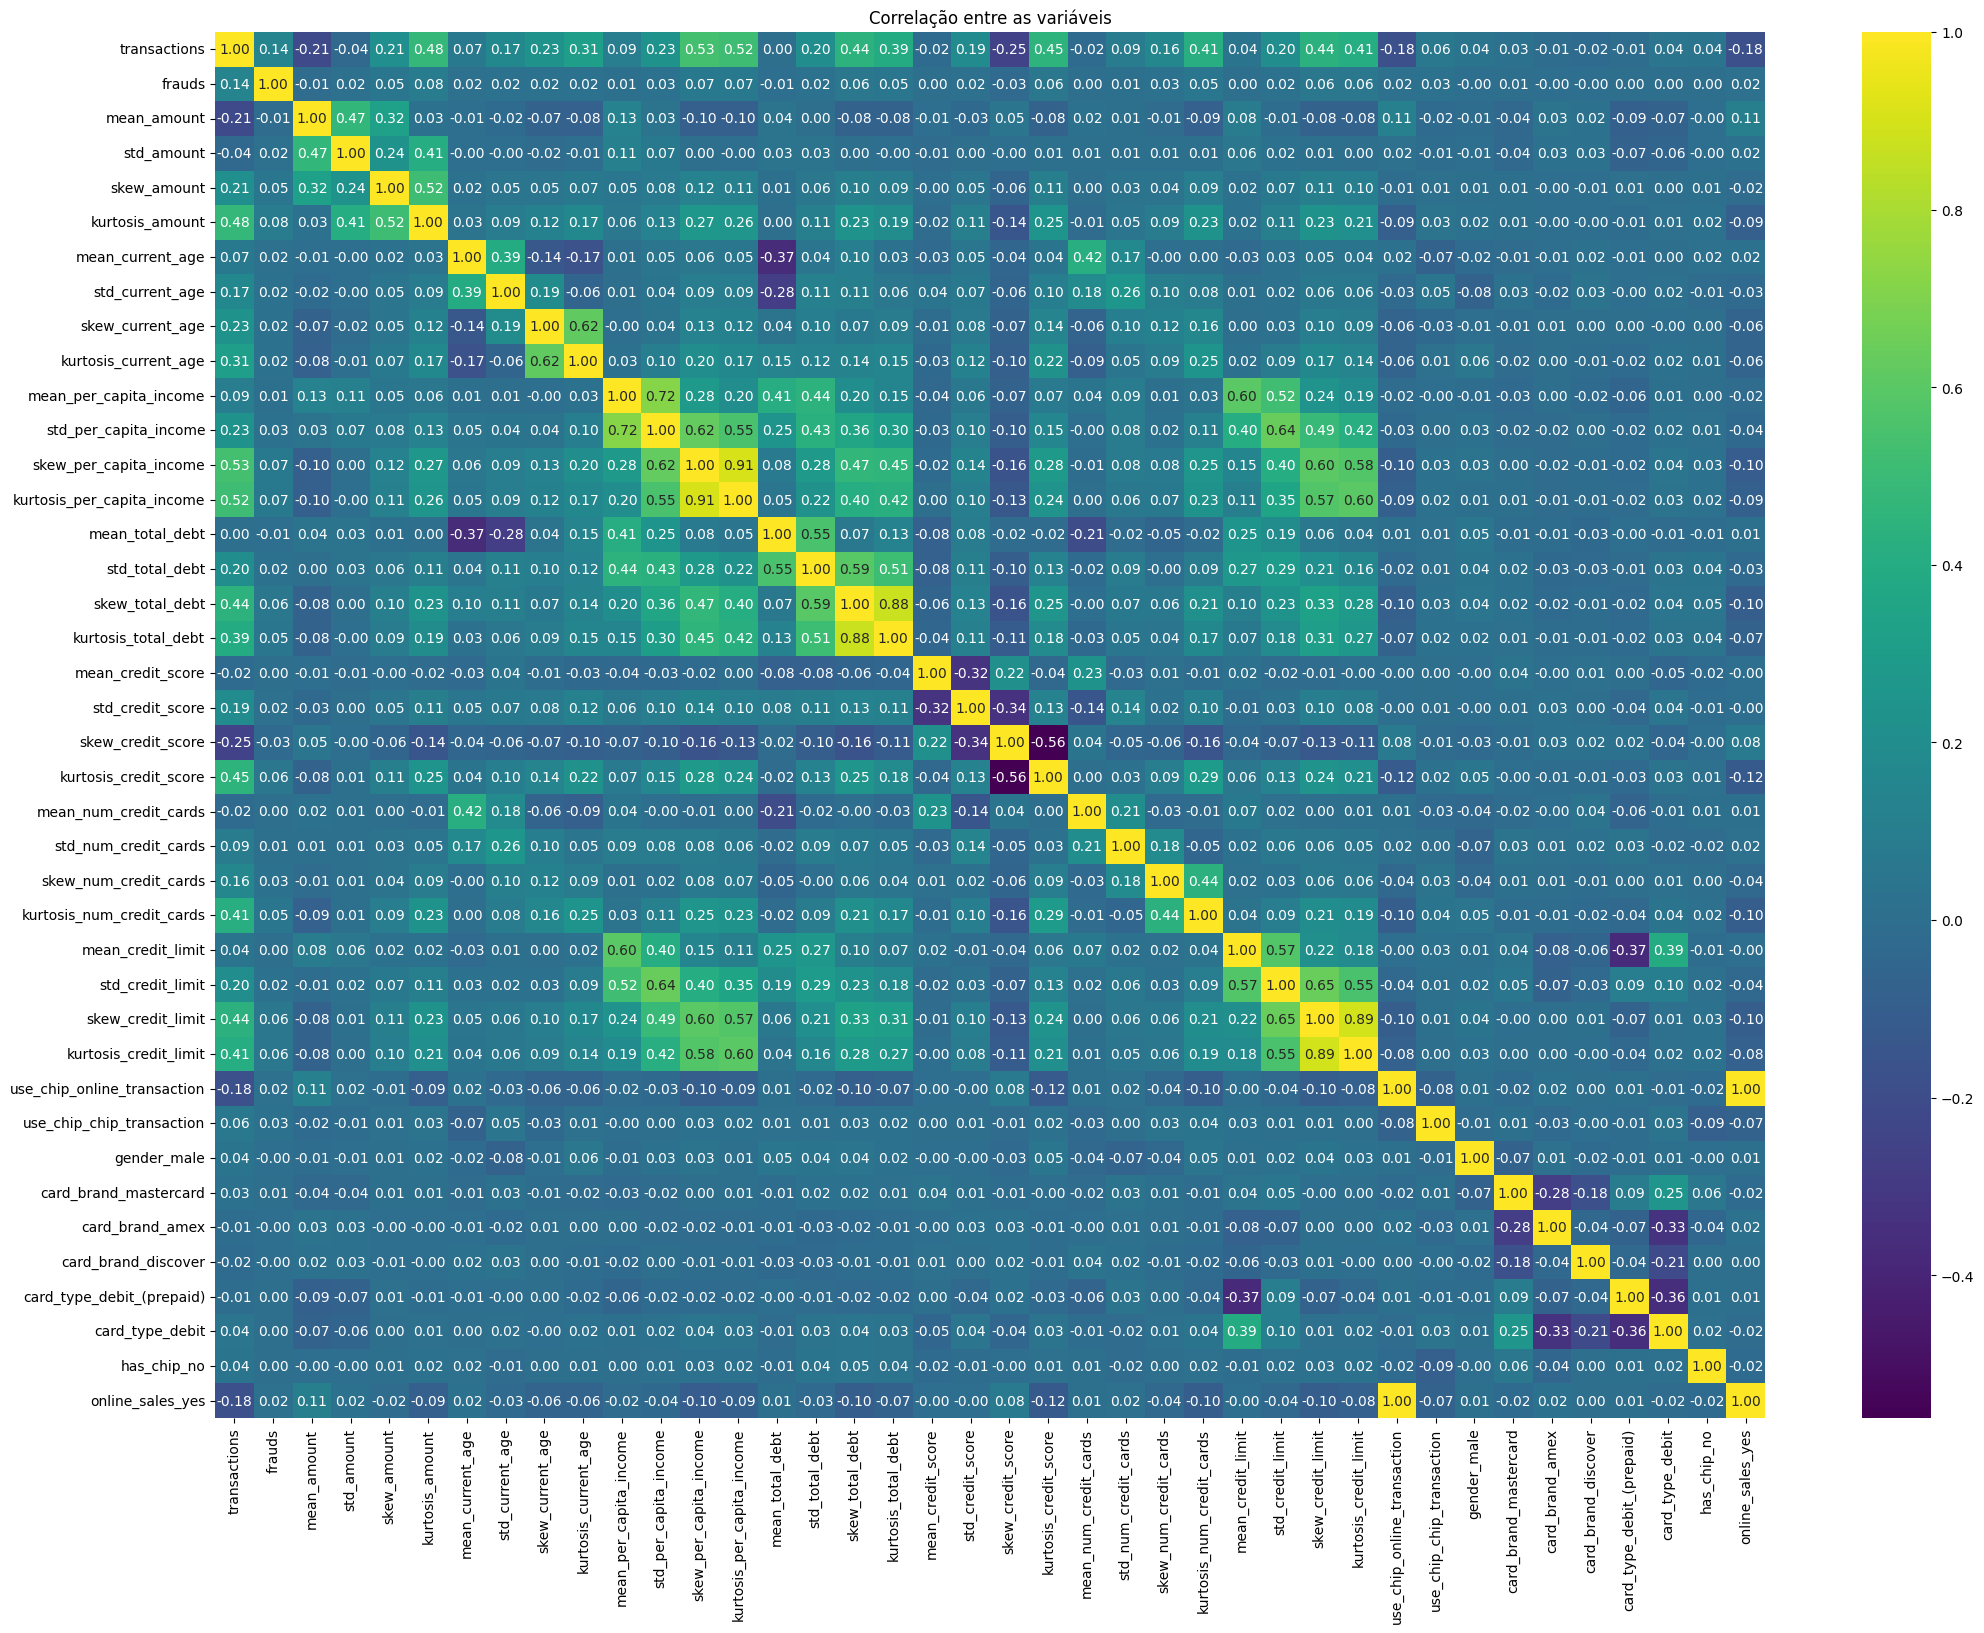

In [87]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [88]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.119668
"""Miscellaneous Food Stores""",0.10986
"""Service Stations""",0.107137
"""Eating Places and Restaurants""",0.075133
"""Drug Stores and Pharmacies""",0.058037


In [89]:
df_proportion.shape

(108, 2)

In [90]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [91]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.870067,7315


In [92]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.129933,6017


In [93]:
def segment_data(categories, prompt):
  response = azure_client.chat.completions.create(
    messages=[
         {
             "role": "system",
             "content": prompt
         },
         {"role": "user", "content": categories}
    ],
    model='o1',
    max_completion_tokens=16000
  )
  return json.loads(response.choices[0].message.content.replace('```json', '').replace('```', ''))

In [94]:
prompt = "Segmente as categorias em grupos com base em suas caracteristicas de forma que esses grupos sejam homogeneos internamente e heterogeneos entre eles. Retorne o resultado no formato json a seguir: [{\"cluster\":\"Saúde e Bem-Estar\",\"items\":[\"Hospitais\",\"Clínicas Médicas\",\"Farmácias\"]}]"

In [95]:
response = segment_data(str.join(';', df['description'].unique().to_list()), prompt)
response

[{'cluster': 'Saúde e Cuidados Pessoais',
  'items': ['Hospitals',
   'Chiropractors',
   'Dentists and Orthodontists',
   'Doctors, Physicians',
   'Podiatrists',
   'Medical Services',
   'Optometrists, Optical Goods and Eyeglasses',
   'Drug Stores and Pharmacies',
   'Beauty and Barber Shops',
   'Cosmetic Stores']},
 {'cluster': 'Alimentação e Restaurantes',
  'items': ['Eating Places and Restaurants',
   'Fast Food Restaurants',
   'Drinking Places (Alcoholic Beverages)',
   'Grocery Stores, Supermarkets',
   'Miscellaneous Food Stores',
   'Package Stores, Beer, Wine, Liquor']},
 {'cluster': 'Moda e Acessórios',
  'items': ['Sports Apparel, Riding Apparel Stores',
   'Family Clothing Stores',
   "Women's Ready-To-Wear Stores",
   'Shoe Stores',
   'Leather Goods']},
 {'cluster': 'Entretenimento e Lazer',
  'items': ['Motion Picture Theaters',
   'Recreational Sports, Clubs',
   'Amusement Parks, Carnivals, Circuses',
   'Athletic Fields, Commercial Sports',
   'Theatrical Produc

In [62]:
items = sum(list(map(lambda x: x['items'], response)), [])
print([item for item in items if item not in df['description'].unique().to_list()])

[]


In [63]:
categories_cluster = sum(list(map(lambda x: [dict(category=x['cluster'], description=item) for item in x['items']], response)), [])
categories_cluster = pl.DataFrame(categories_cluster)
categories_cluster.head()

category,description
str,str
"""Alimentação e Bebidas""","""Package Stores, Beer, Wine, Li…"
"""Alimentação e Bebidas""","""Miscellaneous Food Stores"""
"""Alimentação e Bebidas""","""Grocery Stores, Supermarkets"""
"""Alimentação e Bebidas""","""Eating Places and Restaurants"""
"""Alimentação e Bebidas""","""Fast Food Restaurants"""


In [64]:
df = df.join(categories_cluster, on='description', how='left')
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category,category_right,category_right,category_right,category_right,category_right
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str,str,str,str,str,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""",0,30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No""","""No""","""Beulah""","""United States""",2010-01-01 00:00:00,"""Varejo - Alimentos e Bebidas""","""Food & Beverage""","""Food & Beverage""","""Food & Beverage""","""Food and Beverage Retail and S…","""Alimentação e Bebidas"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""",0,48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No""","""No""","""Bettendorf""","""United States""",2010-01-01 00:00:00,"""Varejo - Itens Diversos""","""Retail - General & Specialty""","""Retail (General & Specialty)""","""Retail & Specialty Stores""","""Retail - General Merchandise""","""Varejo Geral"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""",0,49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No""","""No""","""Vista""","""United States""",2010-01-01 00:00:00,"""Serviços Financeiros e Profiss…","""Professional & Financial Servi…","""Professional & Financial Servi…","""Financial & Insurance""","""Financial and Legal Services""","""Serviços e Profissionais"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…",0,51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No""","""No""","""Harwood""","""United States""",2010-01-01 00:00:00,"""Restaurantes e Bares""","""Food & Beverage""","""Food & Beverage""","""Food & Beverage""","""Food and Beverage Retail and S…","""Alimentação e Bebidas"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""",0,47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No""","""No""","""Bronx""","""United States""",2010-01-01 00:00:00,"""Varejo - Itens Diversos""","""Retail - General & Specialty""","""Retail (General & Specialty)""","""Retail & Specialty Stores""","""Book and Newspaper Retail""","""Varejo Geral"""


In [65]:
df.filter(df['category'].is_null())

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category,category_right,category_right,category_right,category_right,category_right
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str,str,str,str,str,str
7504492,2010-01-08 12:22:00,1567,2916,831.13,"""Swipe Transaction""",41620,"""Virginia Beach""","""VA""",23452.0,"""3005""",null,"""Miscellaneous Metal Fabricatio…",0,43,68,1976,8,"""Female""","""7874 Wessex Street""",42.1,-76.26,19901.0,40576.0,54011.0,747,2,"""Visa""","""Debit""",4516862441362746,"""06/2013""",641,"""YES""",2,17559.0,"""05/2006""",2006,"""No""","""No""","""Virginia Beach""","""United States""",2010-01-08 12:15:00,null,"""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing and Industrial""","""Indústria, Construção e Serviç…"
7523988,2010-01-13 11:38:00,1799,5909,607.7,"""Swipe Transaction""",41620,"""Albuquerque""","""NM""",87120.0,"""3005""",null,"""Miscellaneous Metal Fabricatio…",0,32,55,1987,4,"""Male""","""3249 12th Drive""",47.75,-122.04,51751.0,105515.0,192458.0,646,4,"""Visa""","""Debit""",4461391532392446,"""02/2020""",981,"""YES""",2,47372.0,"""12/2007""",2008,"""No""","""No""","""Albuquerque""","""United States""",2010-01-13 11:30:00,null,"""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing and Industrial""","""Indústria, Construção e Serviç…"
7667094,2010-02-18 15:02:00,858,4735,747.64,"""Swipe Transaction""",41620,"""Tucson""","""AZ""",85713.0,"""3005""",null,"""Miscellaneous Metal Fabricatio…",0,47,67,1972,11,"""Male""","""335 Valley Stream Boulevard""",29.5,-97.44,15092.0,30774.0,51428.0,700,3,"""Visa""","""Credit""",4899127312611091,"""07/2024""",490,"""YES""",2,10700.0,"""09/2009""",2011,"""No""","""No""","""Tucson""","""United States""",2010-02-18 15:00:00,null,"""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing and Industrial""","""Indústria, Construção e Serviç…"
7725233,2010-03-05 09:15:00,1242,4162,527.73,"""Online Transaction""",41620,"""ONLINE""",null,null,"""3005""",null,"""Miscellaneous Metal Fabricatio…",1,52,69,1967,10,"""Female""","""549 Tenth Avenue""",41.83,-87.68,14963.0,30509.0,56953.0,641,2,"""Mastercard""","""Credit""",5684630456479793,"""05/2020""",396,"""YES""",1,6200.0,"""08/2005""",2010,"""No""","""Yes""","""Online""","""Online""",2010-03-05 09:15:00,null,"""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing and Industrial""","""Indústria, Construção e Serviç…"
7767728,2010-03-16 03:32:00,1417,2975,626.59,"""Swipe Transaction""",41620,"""Concordia""","""KS""",66901.0,"""3005""",null,"""Miscellaneous Metal Fabricatio…",0,54,68,1965,3,"""Female""","""336 Catherine Lane""",42.63,-83.61,25838.0,52680.0,87082.0,835,5,"""Mastercard""","""Credit""",5790469227539261,"""10/2022""",1,"""NO""",1,14200.0,"""05/2008""",2016,"""No""","""No""","""Concordia""","""United States""",2010-03-16 03:30:00,null,"""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing & Industrial""","""Manufacturing and Industrial""","""Indústria, Construção e Serviç…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
23160971,2019-06-26 18:37:00,946,5297,266.81,"""Chip Transaction""",41620,"""Virginia Beach""","""VA""",23452.0,"""3005""",null,"""Miscellaneous Met

In [76]:
df.filter(pl.col('id') == pl.lit(7504492))['description'].to_list()

['Miscellaneous Metal Fabrication']

In [50]:
for column in ['category']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

AttributeError: 'NoneType' object has no attribute 'lower'

In [ ]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [ ]:
df_model.to_parquet('./datasets/features_model.parquet')

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  shutil.copy('./datasets/features_model.parquet', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude')